In [1]:
import os, torch, numpy as np
# from sklearn.model_selection import train_test_split
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.svm import SVC 
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
from dotenv import load_dotenv
load_dotenv()
IMAGES_PATH = os.getenv('IMAGES_PATH')
ROOT_DATA_PATH = os.getenv('ROOT_DATA_PATH')
BATCH_SIZE = int(os.getenv('BATCH_SIZE'))
EPOCHS = int(os.getenv('EPOCHS'))
LR = float(os.getenv('LR'))

In [4]:
from preprocess.data_process import get_dataloaders


train_loader, val_loader, test_loader = get_dataloaders()

images, labels = next(iter(test_loader))
print(images[0].shape)
print(labels[0])

Train Set Size: 6000
Val Set Size: 200
Test Set Size: 500
torch.Size([3, 80, 80])
tensor(1)


In [5]:
#Build frozen ResNet‑18 feature extractor
base_model = models.resnet18(pretrained=False)
feature_extractor = nn.Sequential(*list(base_model.children())[:-1]).to(device)
feature_extractor.eval()


/home/public/sgurpree/miniconda3/envs/G-CV-I_Final/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/public/sgurpree/miniconda3/envs/G-CV-I_Final/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [40]:
# from torchsummary import summary
# image = images[0].to(device)
# summary(base_model, image)

In [6]:
@torch.no_grad()
def extract_features(loader):
    feats, labs = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device).float()
        out  = feature_extractor(imgs)        # → [B,512,1,1]
        out  = out.view(out.size(0), -1)      # → [B,512]
        feats.append(out.cpu())
        labs.append(torch.tensor(labels))
    return torch.cat(feats, dim=0), torch.cat(labs, dim=0)

train_feats, train_labels = extract_features(train_loader)
test_feats,  test_labels  = extract_features(test_loader)
print(f"Train feats: {train_feats.shape}, Train labels: {train_labels.shape}")
print(f"Test  feats: {test_feats.shape},  Test labels: {test_labels.shape}")


/tmp/ipykernel_1172402/3533326060.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labs.append(torch.tensor(labels))


Train feats: torch.Size([6000, 512]), Train labels: torch.Size([6000])
Test  feats: torch.Size([500, 512]),  Test labels: torch.Size([500])


In [7]:
# Cell 9: Pure‑PyTorch KNN and evaluation
def knn_predict(test_feats, train_feats, train_labels, k=2):
    dists    = torch.cdist(test_feats, train_feats)  # [N_test,N_train]
    idxs     = dists.topk(k, largest=False).indices  # [N_test,k]
    knn_labs = train_labels[idxs]                    # [N_test,k]
    preds    = []
    for row in knn_labs:
        vals, counts = row.unique(return_counts=True)
        preds.append(vals[counts.argmax()].item())
    return torch.tensor(preds)

k     = 2
preds = knn_predict(test_feats, train_feats, train_labels, k)
acc   = (preds == test_labels).float().mean().item()
print(f"{k}-NN test accuracy: {acc * 100:.2f}%")


2-NN test accuracy: 91.00%


In [8]:
# Convert features and labels from tensors to numpy
X_train = train_feats.numpy()
y_train = train_labels.numpy()
X_test  = test_feats.numpy()
y_test  = test_labels.numpy()

# Train an SVM
svm = SVC(kernel='linear') 
svm.fit(X_train, y_train)

# Predict
svm_preds = svm.predict(X_test)

KNN (k=2) Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       250
           1       0.97      0.95      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



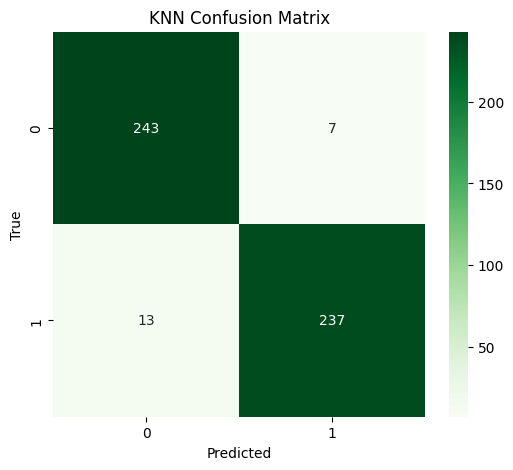

In [44]:
# KNN Report
print("KNN (k=2) Classification Report:")
print(classification_report(test_labels, preds))
#print(classification_report(test_labels, preds))

# KNN Confusion Matrix
cm_knn = confusion_matrix(test_labels, preds)
#cm_knn = confusion_matrix(test_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
#sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


SVM (linear) Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       250
           1       0.98      0.98      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



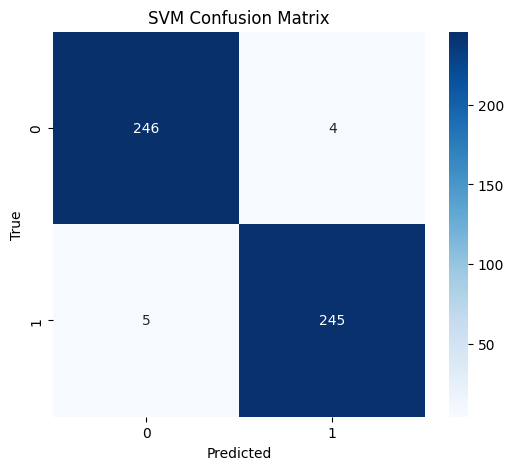

In [45]:
# SVM Report
print("SVM (linear) Classification Report:")
print(classification_report(test_labels, svm_preds))
#print(classification_report(test_labels, svm_preds))

# SVM Confusion Matrix
cm_svm = confusion_matrix(test_labels, svm_preds)
#cm_svm = confusion_matrix(test_labels, svm_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
#sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    )
import matplotlib.pyplot as plt

#Making sure Numpy Arrays
X_train = train_feats.numpy()
y_train = train_labels.numpy()
X_test  = test_feats.numpy()
y_test  = test_labels.numpy()

In [47]:
# Train sklearn k-NN with probability outputs
knn_clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_clf.fit(X_train, y_train)
y_score_knn = knn_clf.predict_proba(X_test)[:, 1]

# Train SVM with probability=True
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)
y_score_svm = svm_clf.predict_proba(X_test)[:, 1]

In [48]:
# Compute Precision–Recall and Average Precision
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_score_knn)
ap_knn = average_precision_score(y_test, y_score_knn)

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_score_svm)
ap_svm = average_precision_score(y_test, y_score_svm)

# Compute ROC and AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
auc_knn = roc_auc_score(y_test, y_score_knn)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_svm = roc_auc_score(y_test, y_score_svm)

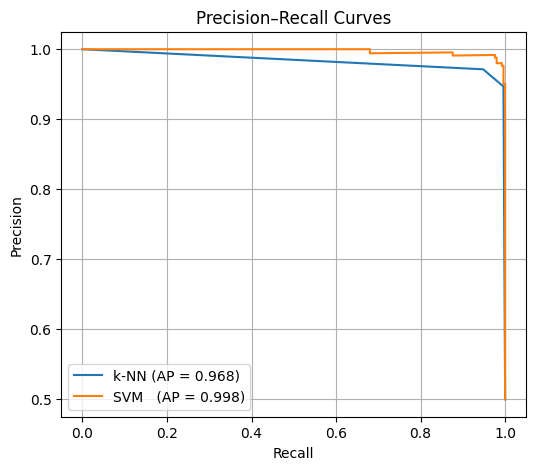

In [49]:
# Plot Precision–Recall curves
plt.figure(figsize=(6,5))
plt.plot(recall_knn, precision_knn, label=f'k-NN (AP = {ap_knn:.3f})')
plt.plot(recall_svm, precision_svm, label=f'SVM   (AP = {ap_svm:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

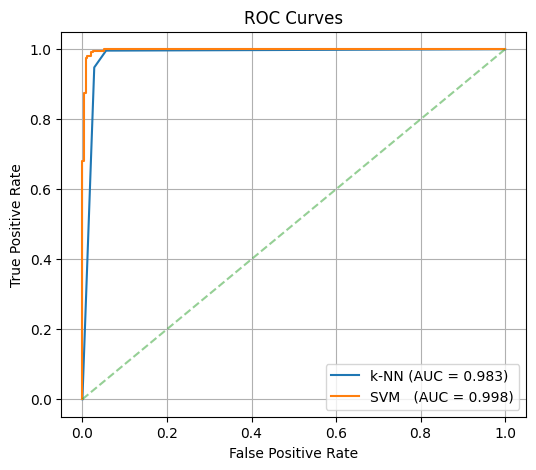

In [50]:
# Plot ROC curves
plt.figure(figsize=(6,5))
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {auc_knn:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM   (AUC = {auc_svm:.3f})')
plt.plot([0,1], [0,1], linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [51]:
print(f"k-NN   → Average Precision (AP): {ap_knn:.3f}, ROC AUC: {auc_knn:.3f}")
print(f"SVM    → Average Precision (AP): {ap_svm:.3f}, ROC AUC: {auc_svm:.3f}")

k-NN   → Average Precision (AP): 0.968, ROC AUC: 0.983
SVM    → Average Precision (AP): 0.998, ROC AUC: 0.998
